This notebook demonstrates inverse kinematics of manipulator using TTGO.

    Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')

from planar_manipulator import PlanarManipulator
from cost_utils import PlanarManipulatorCost
from plot_utils import plot_chain
from utils import test_ttgo
from ttgo import TTGO
import time
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

Define the robot paramters

In [2]:
n_joints = 3
link_lengths = torch.tensor([1.4/n_joints]*n_joints)
max_theta = np.pi/1.1
min_theta = -1*max_theta
robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=5, device='cpu')

Define the cost and the pdf

In [3]:
x_obst = [torch.tensor([0.5,0.5]),torch.tensor([-0.35,0.]),
          torch.tensor([-0.25,0.75]),torch.tensor([0,-0.75])]
r_obst = [0.25,0.15,0.25,0.3]
margin=0.025
w_goal= 0.4; w_obst=0.4; w_orient = 0.2;
b_goal=0.15; b_obst=0.5; b_orient=0.5
costPlanarManipulator = PlanarManipulatorCost(robot,x_obst=x_obst,r_obst=r_obst, margin=margin, 
                                              w_goal=w_goal, w_obst=w_obst, w_orient=w_orient,
                                              b_goal=b_goal, b_obst=b_obst, b_orient=b_orient)
def cost(x):
    return costPlanarManipulator.cost_ik_2(x)[:,0]

def pdf(x):
    return torch.exp(-cost(x)**2)

Discretization of the domain

In [4]:
# Define the range of target poses of the end-effector
pose_max = torch.sum(link_lengths)
pose_min = -1*pose_max

# Discretize the domain
d0_x = 100
d0_theta = 100
domain_task=  [torch.linspace(pose_min,pose_max,d0_x)]*2 + [torch.linspace(0,2*torch.pi,d0_theta)] # position of ee and orientation
domain_decision = [torch.linspace(min_theta,max_theta,d0_theta)]*n_joints # joint angles
domain =  domain_task + domain_decision 


### Fit TT-Model for the PMF

In [5]:
ttgo_0 = TTGO(domain=domain,pdf=pdf, cost=cost)

In [6]:
ttgo_0.cross_approximate(rmax=500, nswp=10, eps=1e-6, kickrank=5) # increase nswp for beter tt model
# saved_model = torch.load('planar_ik.pickle')
# ttgo.tt_model = saved_model['tt_model']
# w_goal,w_obst = saved_model['w']
# b_goal,b_obst = saved_model['b']
# domain = saved_model['domain']
# margin=saved_model['margin']
# x_obst = saved_model['x_obst']
# r_obst = saved_model['r_obst']
# d0_x,d0_theta = saved_model['d0']
# n_joints = saved_model['n_joints']

cross device is cpu
Cross-approximation over a 6D domain containing 1e+12 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0  | tt-new-norm/tt-old-norm: 2.774e-04 | time:   0.0412 | largest rank:   1
iter: 1  | tt-new-norm/tt-old-norm: 2.136e+01 | time:   0.3003 | largest rank:   6
iter: 2  | tt-new-norm/tt-old-norm: 1.658e+00 | time:   1.0650 | largest rank:  11
iter: 3  | tt-new-norm/tt-old-norm: 1.462e+00 | time:   2.6776 | largest rank:  16
iter: 4  | tt-new-norm/tt-old-norm: 1.270e+00 | time:   5.4643 | largest rank:  21
iter: 5  | tt-new-norm/tt-old-norm: 1.138e+00 | time:   9.8982 | largest rank:  26
iter: 6  | tt-new-norm/tt-old-norm: 1.086e+00 | time:  16.0239 | largest rank:  31
iter: 7  | tt-new-norm/tt-old-norm: 1.065e+00 | time:  24.8280 | largest rank:  36
iter: 8  | tt-new-norm/tt-old-norm: 1.081e+00 | time:  35.7458 | largest rank: 

In [7]:
ttgo= ttgo_0.clone()

### Test the model

In [8]:
# Generate test set (feasible target points)
ns = 1000
test_theta = torch.zeros(ns,n_joints)
for i in range(n_joints):
    unif = torch.distributions.uniform.Uniform(low=min_theta,high=max_theta)
    sample = torch.tensor([unif.sample() for i in range(ns)])
    test_theta[:,i] = sample
    
_, _, test_x, test_orient = robot.forward_kin(test_theta)

test_set = torch.cat((test_x,test_orient.view(-1,1),test_theta),dim=-1)
cost_values = costPlanarManipulator.cost_ik_2(test_set)
test_set = test_set[cost_values[:,0]<0.05]
ns = min(test_set.shape[0],50)


In [9]:
# # # Save the model
# file_name = 'planar_ik_orient.pickle'
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst,w_orient),
#     'b': (b_goal,b_obst,b_orient),
#     'd0':(d0_x,d0_theta),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'link_lengths':link_lengths
# }, file_name)


In [10]:
sites_task = [0,1]
ttgo.set_sites(sites_task)
test_task = test_set[:ns, :len(sites_task)]

In [11]:
n_samples_tt = 100
alpha = 0.75
norm=1
print("total-cost | dist-to-goal | num-of-collisions ")
_ = test_ttgo(ttgo=ttgo.clone(), cost= costPlanarManipulator.cost_ik_2, test_task=test_task, 
          n_samples_tt=n_samples_tt,alpha=alpha, norm=norm, device='cpu', test_rand=True)


total-cost | dist-to-goal | num-of-collisions 
################################################################
################################################################
norm:1  |  alpha:0.75  |  n_samples_tt:100  |  n_samples_rand:100 | 
################################################################
################################################################
Cost TT (raw)           :  tensor([0.23, 0.06, 0.00, 0.14])
Cost TT (optimized)     :  tensor([0.01, 0.00, 0.00, 0.01])
Cost rand (raw)           :  tensor([0.90, 0.20, 0.08, 0.74])
Cost rand (optimized)     :  tensor([0.10, 0.03, 0.01, 0.01])
-------------------------------------
Performance, c_total <  0.33  (intersection)
-------------------------------------
Success-rate (tt vs rand) :  1.0 0.92
# iterations (tt vs rand) :  7.739130434782608 10.934782608695652
Cost-mean-tt-raw: tensor([0.22, 0.06, 0.00, 0.13])
Cost-mean-tt-opt: tensor([0.02, 0.00, 0.00, 0.01])
Cost-mean-rand-raw: tensor([0.87, 0.19, 0.08, 0.77])


### Visualization

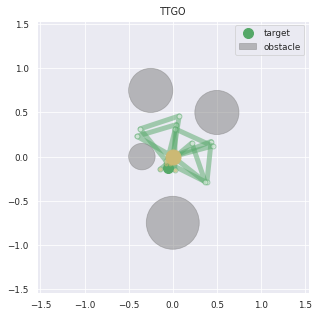

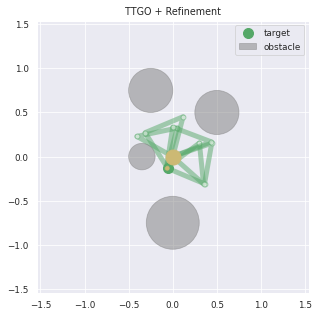

In [12]:
# choose a task-parameter (target position of end-effector)
s = np.random.choice(np.arange(ns))
x_task = test_task[s] 

#torch.tensor([ 0.3472, -0.6735,  3.6776])

# Sample from TT-model
alpha=0.75
n_samples = 100
t1 = time.time()
samples, samples_idx = ttgo.sample(n_samples=n_samples, x_task=x_task, alpha=alpha, norm=1) 
# samples, samples_idx = ttgo.sample_random(n_samples=5*n_samples, x_task=x_task) 

# Fine tune the approximation
best_estimate_tt = ttgo.choose_best_sample(samples)
best_estimate_tt_opt = ttgo.optimize(best_estimate_tt)
t2 = time.time()

# For multiple solutions
k = 5
top_k_estimate_tt = ttgo.choose_top_k_sample(samples,k)
top_k_estimate_tt_opt = 1*top_k_estimate_tt
for i in range(top_k_estimate_tt.shape[0]):
    top_k_estimate_tt_opt[i], _ = ttgo.optimize(top_k_estimate_tt[i])


figsize=5    
    
_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt[:,3:])
joint_loc = joint_loc.numpy()
link = link_lengths.numpy()
x_obst_np = [x.numpy() for x in x_obst]
x_target = [x_task[:2].numpy()]

title = "TTGO"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1,figsize=figsize, title=title, save_as=None, 
           color_intensity=0.9, motion=False, alpha=0.5, contrast=0.3,lw=5)
# plt.savefig("twoD-3n-ik-5.png",dpi=300, pad_inches=0.01, motion="False")


_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt_opt[:,3:])
joint_loc = joint_loc.numpy()
link = link_lengths.numpy()
x_obst_np = [x.numpy() for x in x_obst]
title = "TTGO + Refinement"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1, figsize=figsize, title=title, save_as=None, 
           color_intensity=0., motion=False, alpha=0.5, contrast=0., task='ik',lw=5)